In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
plt.style.use("dark_background")

from sklearn.model_selection import train_test_split

In [2]:
import seaborn as sns

df_iris = sns.load_dataset("iris")

In [3]:
from sklearn.preprocessing import LabelEncoder
#transformamos las etiquetas (y) de los datos a ser números desde 0 a n_clases-1
label_enc = LabelEncoder()

labels = label_enc.fit_transform(df_iris.species)

X = torch.tensor(df_iris.iloc[:,0:4].values).float() #matriz de características
y = torch.tensor(labels).long() #vector de las etiquetas transformadas a números (tipo de dato long() -> entero) #podiamos tambien haber hecho df.iris[df.iris.species=="setosa"] == 1 y así

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [7]:
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

In [8]:
batch_size = 16 #suelen ser potencias de 2

train_loader = DataLoader(train_data,
                         batch_size=batch_size,
                         shuffle=True)

test_loader = DataLoader(test_data,
                        batch_size=test_data.tensors[0].shape[0])
#train_data.tensors[0] accede a las características X
#para predicciones del modelo, los lotes son individuales

<img src="dropout details.jpg" alt="info" width=500>

In [14]:
class Model(nn.Module):
    
    def __init__(self, dropout_rate):
        
        super().__init__()
        
        self.inp = nn.Linear(train_data.tensors[0].shape[1], 12)
        self.hid = nn.Linear(12,12)
        self.out = nn.Linear(12,len(train_data.tensors[1].unique()))
        
        
        #el atributo referente a la proporción de dropout
        self.dr = dropout_rate
        
    def forward(self, x):
        
        x = F.relu(self.inp(x))
        #dropout tras esta capa, tan solo aplicado si el booleano self.training = True
        x = F.dropout(x, p=self.dr,
                     training=self.training)
        
        x = F.relu(self.hid(x))
        
        x = F.dropout(x, p=self.dr, #dropout (si el modelo esta en modo train())
                     training=self.training)
        
        x = self.out(x) #aquí no aplicamos dropout, ya que al haber un nodo inhibiría la salida del modelo
        
        return x

In [16]:
model = Model(dropout_rate=0.25)

#testeando una inferencia del modelo
model(torch.rand((1,train_data.tensors[0].shape[1])))

tensor([[ 0.1268, -0.0774, -0.1351]], grad_fn=<AddmmBackward0>)

In [40]:
n_epochs = 500

In [47]:
def create_model(dr_rate):
    
    model = Model(dr_rate)
    loss_func = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(params=model.parameters(),
                       lr=0.005)
    
    return model, loss_func, optim

In [48]:
def train_model(model, loss_func, optim):
    
    train_accs = []
    test_accs = []
    
    
    for epoch in range(n_epochs):
        
        model.train() #activamos el modo train(). Esto servirá para activar dropout

        
        batch_accs = []
        
        for (X_batch, y_batch) in train_loader:
            
            y_hat = model(X_batch)
            
            loss = loss_func(y_hat, y_batch)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            

            batch_accs.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y_batch).float()).item())
        
        train_accs.append(np.mean(batch_accs))
        
        #test
        model.eval() #aseguramos desactivar dropout
        X_test, y_test = next(iter(test_loader)) #extraemos los datos del generador
        preds = model(X_test)
        test_accs.append(100*torch.mean((torch.argmax(preds, axis=1) == y_test).float()).item())
        
    
    return train_accs, test_accs

In [49]:
dropout_rate = 0.0
model, loss_func, optim = create_model(dropout_rate)

train_accs, test_accs = train_model(model, loss_func, optim)

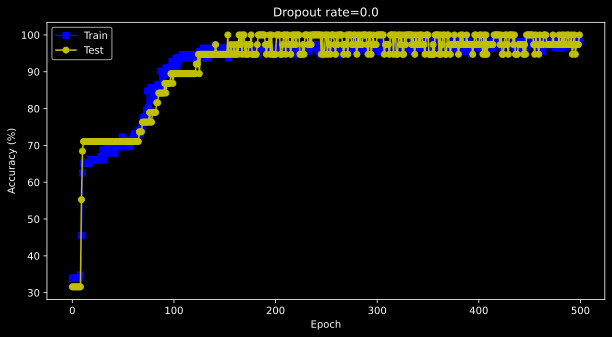

In [50]:
fig = plt.figure(figsize=(10,5))

plt.plot(train_accs, "bs-")
plt.plot(test_accs, "yo-");
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(["Train", "Test"]);
plt.title(f"Dropout rate={dropout_rate}");

Vemos en este ejemplo que quizás el dropout no sería una buena práctica ya que el modelo alcanza unos buenos resultados tanto en training como en testing

## Hora del Experimento

In [51]:
dropout_rates = np.arange(10)/10 #vector de valores de 0.0 a 0.9
results = np.zeros((len(dropout_rates), 2))

In [56]:
n_epochs = 500

In [57]:
from tqdm import tqdm

In [58]:
for idx in tqdm(range(len(dropout_rates))):
    
    
    model, loss_func, optim = create_model(dropout_rates[idx])
    
    train_accs, test_accs = train_model(model, loss_func, optim)
    
    #tomaremos la media de las precisiones de las últimas 100 epochs
    #debido a que será más preciso conocer su desempeño en las últimas epochs
    results[idx,0] = np.mean(train_accs[-100:])
    results[idx,1] = np.mean(test_accs[-100:])

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.43s/it]


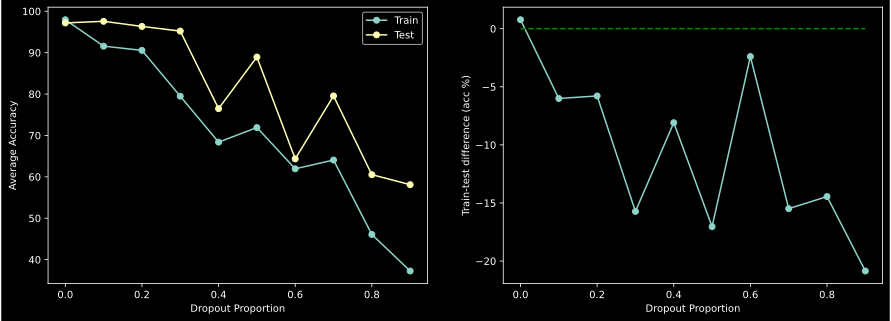

In [60]:
fig, axs = plt.subplots(1,2, figsize=(15,5), sharex=True)

axs[0].plot(dropout_rates,results, "o-")
axs[0].set_xlabel("Dropout Proportion")
axs[0].set_ylabel("Average Accuracy")
axs[0].legend(["Train", "Test"])

axs[1].plot(dropout_rates, -np.diff(results, axis=1), "o-")
axs[1].plot([0,.9], [0,0], "g--") #trazamos para diferencia = 0
axs[1].set_xlabel("Dropout Proportion")
axs[1].set_ylabel("Train-test difference (acc %)")
plt.show()

Vemos que, efectivamente, el modelo parece funcionar correctamente sin necesidad de dropout